In [1]:
import nomic
import json

api_key_path = "/home/paperspace/api_keys.json"

with open(api_key_path, 'r') as j:
    key = json.loads(j.read())['nomic']

nomic.login(key)
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer
import torch

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')

bill_id = '118-2024_h142'

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent

df_bill = pd.read_csv(f'/home/paperspace/congressional-twin/data/data/{bill_id}.csv', header=1)
congress_name_list_bill=df_bill['matched-name'].unique()
congress_name_list_bill = [name for name in congress_name_list_bill if pd.notnull(name)][:-1]

df.head()

/home/paperspace/venvs/pnma/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-10-17 20:28:55.186 | INFO     | nomic.dataset:__init__:761 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-17 20:28:56.087 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-17 20:28:56.088 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 11139.91it/s]
2024-10-17 20:28:56.404 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|████████████████████

,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [2]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [3]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
<All keys matched successfully>


In [4]:
t = pd.Timestamp(year=2024, month=1, day=1)
# t = pd.Timestamp(year=2017, month=7, day=28)

congress_name_list= list(df['name'].unique())    
name_to_standardized_name = {}

cp_metadata = {}

#- Add all congress persons in Atlas dataframe to name_to_standardized_name
for name in congress_name_list:
    key = name
    name = name.lower()
    chunks = name.split(' ')[:2]
    if ',' in chunks[0]:
        name = chunks[1] + '_' + chunks[0][:-1]
    else:
        name = chunks[0] + '_' + chunks[1]
        
    name_to_standardized_name[key] = unidecode(name)
    party=df[df['name'] == key]['party'].values[0]

    if key in congress_name_list_bill:
        vote = df_bill[df_bill['matched-name'] == key]['vote'].values[0]
    else:
        vote = 'n/a'
        
    cp_metadata[name] = {'party': party, 'vote': vote}
    
standardized_name_list = list(name_to_standardized_name.values())

n_congresspersons = len(congress_name_list)
all_text = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
all_embds = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

for i, embd in enumerate(tqdm(embds)):
    congress_name = name_to_standardized_name[df['name'][i]]
    posted_at = df['postedAt'][i]
    
    if posted_at > t:
        key='post-t'
    else:
        key='pre-t'
        
    all_text[congress_name][key].append(df['text'][i])
    all_embds[congress_name][key].append(embd)
    
for name in standardized_name_list:
    all_embds[name]['post-t'] = np.array(all_embds[name]['post-t'])
    all_embds[name]['pre-t'] = np.array(all_embds[name]['pre-t'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3214913/3214913 [00:57<00:00, 56076.23it/s]


In [11]:
## GPT-4o generation of questions for bill https://www.govtrack.us/congress/votes/115-2017/s179 

questions = [
    "What do you believe is the best approach to ensure universal access to affordable health care in the U.S.?",
    "How would you address the rising costs of prescription medications in a way that benefits both consumers and pharmaceutical companies?",
    "Do you support expanding Medicare or Medicaid, and why or why not?",
    "What role should the federal government play in regulating health insurance providers?",
    "How do you plan to balance the needs of health care providers with the financial constraints faced by patients, especially low-income families?",
    "What are your views on the role of private versus public health care options in the U.S. system?",
    "How do you plan to ensure that rural and underserved communities have access to quality health care services?",
    "What steps would you take to ensure that individuals with pre-existing conditions maintain access to affordable health care?",
    "Do you believe the U.S. should transition to a single-payer health care system? Why or why not?",
    "How would you address the ongoing debate about health care reform and its intersection with issues like mental health services, reproductive health, and senior care?"
]

questions = [
    "What is your rationale for supporting or opposing the emergency supplemental appropriations to respond to the situation in Israel?",
    "How do you believe the allocated funds will effectively address the current needs in Israel?",
    "What measures are in place to ensure that the emergency funds are used efficiently and transparently?",
    "How does this supplemental appropriation align with your broader foreign policy objectives in the Middle East?",
    "What impact do you anticipate this aid will have on the stability and security of the region?",
    "How do you respond to concerns about the potential long-term financial implications of this emergency funding?",
    "In what ways does this appropriation support the humanitarian needs of civilians affected by the situation in Israel?",
    "How are you addressing the views and concerns of your constituents regarding the allocation of funds to Israel?",
    "What oversight mechanisms do you advocate for to monitor the effectiveness of the emergency supplemental appropriations?",
    "How does providing this emergency funding to Israel affect the United States’ relationships with other allies and partners in the region?"
]

embedded_questions = embedding_model.encode(questions)

In [113]:
np.random.seed(1)
shuffled_cps = np.random.choice(standardized_name_list, len(standardized_name_list), replace=False)

# timeframes = ['pre-t', 'post-t']
# sampled_tweet_dict = {}

# name = 'morgan_griffith'
# tweets = all_text[name]['post-t']
# shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
# sampled_tweet_dict[name] = {'retrieved': {q: [] for q in questions}, 
#                             'generated': {q: [] for q in questions},
# }

n_cps = 500
for name in shuffled_cps:
    #- only consider n_cps congresspersons
    if len(sampled_tweet_dict) >= n_cps:
        break
        
    if name in sampled_tweet_dict:
        continue
        
    try:
        proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
        proper=True
    except:
        proper=False
        
    if not proper:
        continue
        
    #- only consider congresspersons with enough tweets after t
    if len(all_text[name]['pre-t']) == 0:
        continue
        
    shuffled_tweets = np.random.choice(tweets, len(tweets), replace=False)
    sampled_tweet_dict[name] = {'retrieved': {q: [] for q in questions}, 
                                'generated': {q: [] for q in questions},
    }

sampled_name_list = list(sampled_tweet_dict.keys())
len(sampled_name_list), sampled_name_list[:10]

(500,
 ['morgan_griffith',
  'henry_cuellar',
  'veronica_escobar',
  'ed_royce',
  'jared_huffman',
  'brian_mast',
  'byron_donalds',
  'maria_salazar',
  'michael_cloud',
  'jay_obernolte'])

In [116]:
terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id
pipeline.tokenizer.padding_side = 'left'

for name in tqdm(sampled_tweet_dict):
    proper_noun_name = capitalize_first_letters(name.replace('_', ' '))
    system_prompt = f"You are U.S. congressperson {proper_noun_name}."
    
    retrieved_tweet_indices = np.argmax(all_embds[name]['pre-t'] @ embedded_questions.T, axis=0)
                
    message_list = []
    for i,question in enumerate(questions):
        if len(sampled_tweet_dict[name]['generated'][question]) > 0:
            already_done = True
            break
        else:
            already_done = False
            
            
        retrieved_tweet = all_text[name]['pre-t'][retrieved_tweet_indices[i]]
        sampled_tweet_dict[name]['retrieved'][question] = retrieved_tweet

        user_prompt = f'Write a Tweet that addresses the following question: "{question}".'
        user_prompt += f' Here is an example Tweet potentially related to the to-be-completed Tweet: "{retrieved_tweet}".'
        user_prompt += ' Start your response with "Here is the full Tweet:".'

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]

        message_list.append(messages)
        
    if not already_done:
        outputs = pipeline(
            message_list,
            batch_size=50,
            max_new_tokens=64,
            eos_token_id=terminators,
            do_sample=True,
            temperature=1,
            num_return_sequences=5
        )

        for i,question in enumerate(questions):
            temp_outputs=outputs[i]
            sampled_tweet_dict[name]['generated'][question] = [o["generated_text"][-1]['content'] for o in temp_outputs]
            sampled_tweet_dict[name]['generated'][question] = [t.split('Here is the full Tweet:')[-1].strip() for t in sampled_tweet_dict[name]['generated'][question]]
            sampled_tweet_dict[name]['generated'][question] = [remove_quotes(t) for t in sampled_tweet_dict[name]['generated'][question] if len(t) > 0]

  8%|██████████▋                                                                                                                       | 41/500 [04:14<59:03,  7.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 15%|███████████████████▌                                                                                                              | 75/500 [08:36<54:37,  7.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 22%|████████████████████████████                                                                                                     | 109/500 [12:57<50:21,  7.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 29%|████████████████████████████████████▉                                                                                            | 143/500 [17:20<45:39,  7.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 35%|█████████████████████████████████████████████▋                                                                                   | 177/500 [21:43<41:57,  7.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 42%|██████████████████████████████████████████████████████▍                                                                          | 211/500 [26:05<37:20,  7.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 49%|███████████████████████████████████████████████████████████████▏                                                                 | 245/500 [30:26<32:41,  7.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 279/500 [34:48<28:24,  7.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 313/500 [39:10<23:55,  7.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 347/500 [43:32<19:46,  7.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 381/500 [47:53<15:19,  7.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 415/500 [52:15<10:52,  7.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 449/500 [56:38<06:34,  7.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 483/500 [1:01:01<02:12,  7.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:03:13<00:00,  7.59s/it]


In [117]:
import pickle

pickle.dump(sampled_tweet_dict, open(f'inference_{bill_id}_sampled_tweet_dict.p', 'wb'))

In [118]:
try:
    pipline.model.to('cpu')
    embedding_model.to('cpu')
    del pipeline, embedding_model
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass
    
import pickle
bill_id = '118-2024_h142'

sampled_tweet_dict = pickle.load(open(f'inference_{bill_id}_sampled_tweet_dict.p', 'rb'))
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

<All keys matched successfully>


In [119]:
_sampled_tweet_dict = {}
for name in sampled_tweet_dict:
    empty = False
    for type_ in sampled_tweet_dict[name]:
        for question in questions:
            if len(sampled_tweet_dict[name][type_][question]) == 0:
                empty=True
    if not empty:
        _sampled_tweet_dict[name] = sampled_tweet_dict[name].copy()
sampled_tweet_dict=_sampled_tweet_dict.copy()

In [228]:
filtered_tweet_dict = {}
for name in sampled_tweet_dict:
    filtered_tweet_dict[name] = {}
    for type_ in sampled_tweet_dict[name]:
        filtered_tweet_dict[name][type_] = {}
        for question in sampled_tweet_dict[name][type_]:
            temp = []
            for response in sampled_tweet_dict[name][type_][question]:
                if 'I cannot' not in response:
                    temp.append(response)
            filtered_tweet_dict[name][type_][question] = temp

In [229]:
matrix_representations = {}

for name in filtered_tweet_dict:
    matrix_representations[name] = {}
    
    matrix_representations[name]['retrieved'] = list(filtered_tweet_dict[name]['retrieved'].values())
    matrix_representations[name]['retrieved'] = embedding_model.encode(matrix_representations[name]['retrieved'])
    
    matrix_representations[name]['generated'] = []
    for question in questions:
        temp = filtered_tweet_dict[name]['generated'][question]
        
        if len(temp) == 0:
            matrix_representations[name]['generated'].append([])
        else:
            temp = embedding_model.encode(temp)
            mean = np.mean(temp, axis=0)
            matrix_representations[name]['generated'].append(mean)

In [234]:
for i, question in enumerate(questions):
    question_average = []
    for name in filtered_tweet_dict:
        if len(matrix_representations[name]['generated'][i]) != 0:
            question_average.append(matrix_representations[name]['generated'][i])

    question_average = np.mean(question_average, axis=0)
    
    for name in filtered_tweet_dict:
        if len(matrix_representations[name]['generated'][i]) == 0:
            matrix_representations[name]['generated'][i] = question_average

In [236]:
name_list = list(sampled_tweet_dict.keys())
dist_matrix_retrieved = np.zeros((len(name_list), len(name_list)))
dist_matrix_generated = np.zeros((len(name_list), len(name_list)))

for i, name1 in enumerate(name_list):
    r1 = np.array(matrix_representations[name1]['retrieved'])
    g1 = np.array(matrix_representations[name1]['generated'])
    for ii, name2 in enumerate(name_list[i+1:], i+1):
        r2 = np.array(matrix_representations[name2]['retrieved'])
        g2 = np.array(matrix_representations[name2]['generated'])
        
        dist_matrix_retrieved[i, ii] = np.linalg.norm(r1-r2)
        dist_matrix_retrieved[ii, i] = dist_matrix_retrieved[i, ii]
    
        dist_matrix_generated[i, ii] = np.linalg.norm(g1-g2)
        dist_matrix_generated[ii, i] = dist_matrix_generated[i, ii]

In [237]:
from graspologic.embed import ClassicalMDS

cmds_dict = {}
cmds_dict['retrieved'] = ClassicalMDS().fit_transform(dist_matrix_retrieved)
cmds_dict['generated'] = ClassicalMDS().fit_transform(dist_matrix_generated)

print(cmds_dict['retrieved'].shape[1], cmds_dict['generated'].shape[1])

4 3


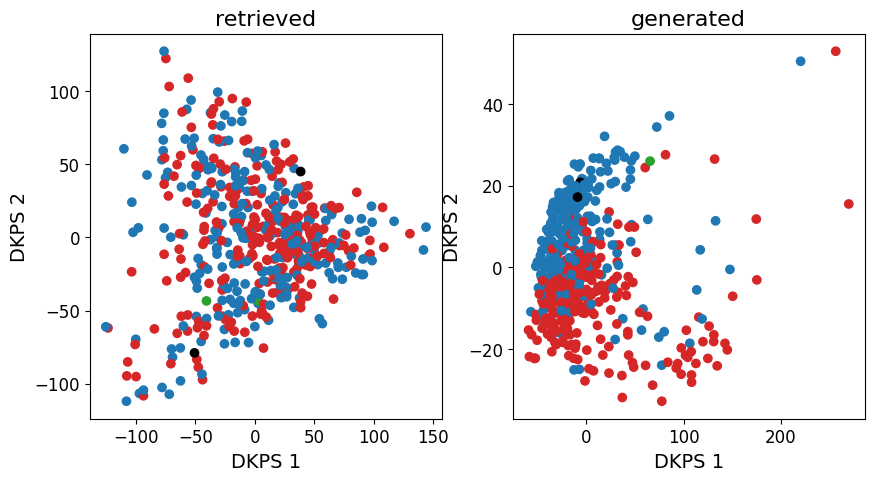

In [238]:
from graspologic.plot import pairplot, heatmap

party_list = np.array([cp_metadata[name]['party'] if name in cp_metadata else 'n/a' for name in sampled_tweet_dict])
party_color_dict = {'D': 'tab:blue', 'R': 'tab:red', 'I': 'tab:green', 'n/a': 'k'}

vote_list = np.array([cp_metadata[name]['vote'] if name in cp_metadata else 'n/a' for name in sampled_tweet_dict])
vote_color_dict = {'Nay': 'tab:red', 'Yea': 'tab:green', 'Not Voting': 'tab:olive', 'n/a': 'k'}

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(cmds_dict['retrieved'][:, 0], cmds_dict['retrieved'][:, 1], c=[party_color_dict[p] for p in party_list])
axs[0].set_title('retrieved', fontsize=16)

axs[1].scatter(cmds_dict['generated'][:, 0], cmds_dict['generated'][:, 1], c=[party_color_dict[p] for p in party_list])
axs[1].set_title('generated', fontsize=16)

for ax in axs:
    ax.tick_params(labelsize=12)
    ax.set_xlabel('DKPS 1', fontsize=14)
    ax.set_ylabel('DKPS 2', fontsize=14)

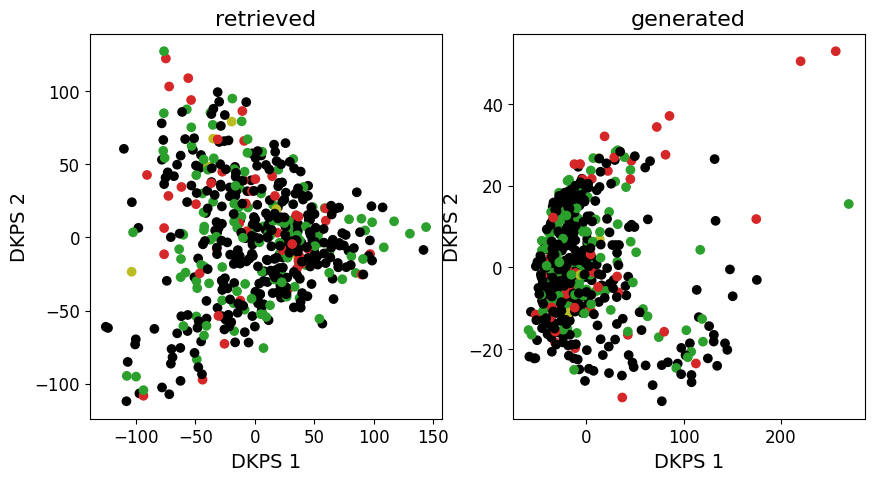

In [239]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(cmds_dict['retrieved'][:, 0], cmds_dict['retrieved'][:, 1], c=[vote_color_dict[v] for v in vote_list])
axs[0].set_title('retrieved', fontsize=16)

axs[1].scatter(cmds_dict['generated'][:, 0], cmds_dict['generated'][:, 1], c=[vote_color_dict[v] for v in vote_list])
axs[1].set_title('generated', fontsize=16)

for ax in axs:
    ax.tick_params(labelsize=12)
    ax.set_xlabel('DKPS 1', fontsize=14)
    ax.set_ylabel('DKPS 2', fontsize=14)

In [240]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def get_stratified_sample(y, p):
    unique = np.unique(y)
            
    inds = []
    for c in unique:
        indices = np.where(y == c)[0]
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict


voter_inds = np.array([i for i, v in enumerate(vote_list) if v in ['Yea', 'Nay']])
vote_list[voter_inds][party_list[voter_inds] == 'D']
n_voters = len(voter_inds)

n_mc=100
p_train = 0.7

n_neighbors_list = [1,2,5,10,20,50,100]

results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}

for k in [1,2,5,10,20,50, 100]:
    for mc in range(n_mc):
        train_inds = get_stratified_sample(vote_list[voter_inds], p=p_train)
        test_inds = np.array([i for i in range(n_voters) if i not in train_inds])

        for type_, cmds in cmds_dict.items():
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(cmds[voter_inds][train_inds], vote_list[voter_inds][train_inds])

            y_pred = model.predict(cmds[voter_inds][test_inds])
            results_dict[k][type_].append(balanced_accuracy_score(vote_list[voter_inds][test_inds], y_pred))
            
            
        #- majority
        unique, return_counts = np.unique(vote_list[voter_inds][train_inds], return_counts=True)
        y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
        results_dict[k]['majority'].append(balanced_accuracy_score(vote_list[voter_inds][test_inds], y_pred))
        
        
        #- party line vote
        y_pred = [get_party_line(vote_list[voter_inds], party_list[voter_inds])[p] for p in party_list[voter_inds][test_inds]]
        results_dict[k]['party-line'].append(balanced_accuracy_score(vote_list[voter_inds][test_inds], y_pred))
        
            
    print(f'n neighbors = {k}')

    for type_, results in results_dict[k].items():
        print(type_, np.mean(results))
    print()

n neighbors = 1
retrieved 0.5008834586466165
generated 0.5832518796992481
majority 0.5
party-line 0.5

n neighbors = 2
retrieved 0.4896052631578947
generated 0.5916353383458648
majority 0.5
party-line 0.5

n neighbors = 5
retrieved 0.4935714285714285
generated 0.5105451127819548
majority 0.5
party-line 0.5

n neighbors = 10
retrieved 0.4832894736842105
generated 0.4885902255639097
majority 0.5
party-line 0.5

n neighbors = 20
retrieved 0.49798872180451126
generated 0.4982706766917293
majority 0.5
party-line 0.5

n neighbors = 50
retrieved 0.5
generated 0.5
majority 0.5
party-line 0.5

n neighbors = 100
retrieved 0.5
generated 0.5
majority 0.5
party-line 0.5



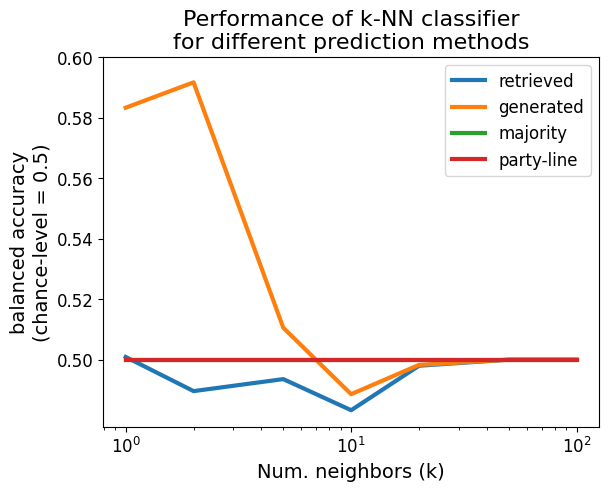

In [242]:
fig, ax = plt.subplots(1,1)

means_dict = {method: [] for method in results_dict[n_neighbors_list[0]]}
for k in n_neighbors_list:
    for method in results_dict[k]:
        temp_mean = np.mean(results_dict[k][method])
        means_dict[method].append(temp_mean)
        
for method, mean in means_dict.items():
    ax.semilogx(n_neighbors_list, mean, lw=3, label=method)
    
ax.set_ylabel('balanced accuracy\n(chance-level = 0.5)', fontsize=14)
ax.set_yticks([0.5, 0.52, 0.54, 0.56, 0.58, 0.6])
ax.tick_params(labelsize=12)

ax.set_xlabel('Num. neighbors (k)', fontsize=14)
ax.set_title('Performance of k-NN classifier\nfor different prediction methods', fontsize=16)
    
ax.legend(fontsize=12)